#### Feature Engineering pour la prédiction du prix Bitcoin

Ce module contient toutes les fonctions pour créer les features
à partir des données OHLCV brutes.

In [140]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, isnan, row_number, lead, lag, avg
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
spark = SparkSession.builder \
    .appName("Bitcoin") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

In [142]:
def load_data(path: str):
    """Charge les fichiers parquet de la zone Silver"""
    df = spark.read.parquet(path)
    return df

df_silver = load_data("../../Data/Silver")
df_silver.show()

+-------------------+--------+--------+--------+--------+-------+--------------------+------------------+----------------+---------------------+----------------------+---------------+----------+--------------------+-----------------+-----------------+-------------------+
|          open_time|    open|    high|     low|   close| volume|          close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|close_t_plus_10|prev_close|              return|             MA_5|            MA_10|        taker_ratio|
+-------------------+--------+--------+--------+--------+-------+--------------------+------------------+----------------+---------------------+----------------------+---------------+----------+--------------------+-----------------+-----------------+-------------------+
|2026-01-18 21:41:00|95380.76|95380.77|95380.76|95380.76|0.30774|2026-01-18 21:41:...|     29352.4770786|              81|              0.19962|         19039.9093074|        95400.0| 

In [143]:
df_silver.printSchema()

root
 |-- open_time: timestamp_ntz (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- close_time: timestamp_ntz (nullable = true)
 |-- quote_asset_volume: double (nullable = true)
 |-- number_of_trades: long (nullable = true)
 |-- taker_buy_base_volume: double (nullable = true)
 |-- taker_buy_quote_volume: double (nullable = true)
 |-- close_t_plus_10: double (nullable = true)
 |-- prev_close: double (nullable = true)
 |-- return: double (nullable = true)
 |-- MA_5: double (nullable = true)
 |-- MA_10: double (nullable = true)
 |-- taker_ratio: double (nullable = true)



In [144]:
# Vérifie si les features requises existent
features_requises = ["close_t_plus_10", "return", "MA_5", "MA_10", "taker_ratio"]

print("\nVerification des features:")
for feature in features_requises:
    existe = feature in df_silver.columns
    print(f"  {feature}: {'OK' if existe else 'MANQUANT'}")


Verification des features:
  close_t_plus_10: OK
  return: OK
  MA_5: OK
  MA_10: OK
  taker_ratio: OK


In [145]:
from pyspark.sql.functions import col, isnan, sum
from pyspark.sql.types import DoubleType, FloatType

# Vérifier les NULLs
null_counts = df_silver.select([
    sum(col(c).isNull().cast("int")).alias(c) 
    for c in df_silver.columns
])
print("Valeurs NULL par colonne:")
null_counts.show()

Valeurs NULL par colonne:
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+---------------+----------+------+----+-----+-----------+
|open_time|open|high|low|close|volume|close_time|quote_asset_volume|number_of_trades|taker_buy_base_volume|taker_buy_quote_volume|close_t_plus_10|prev_close|return|MA_5|MA_10|taker_ratio|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+---------------+----------+------+----+-----+-----------+
|        0|   0|   0|  0|    0|     0|         0|                 0|               0|                    0|                     0|              0|         0|     0|   0|    0|          0|
+---------+----+----+---+-----+------+----------+------------------+----------------+---------------------+----------------------+---------------+----------+------+----+-----+-----------+



In [146]:
# # Target: prix futur à T+10
target = "close_t_plus_10"

num_cols = [
    # Prix
    'open',
    'high',
    'low',
    'close',
    
    
    # Volumes
    
    'volume',
    'quote_asset_volume',
    'taker_buy_base_volume',
    'taker_buy_quote_volume',
    
    # Features calculées
    'MA_10',
    'prev_close',
    'return',
    'MA_5',
    'taker_ratio'
]

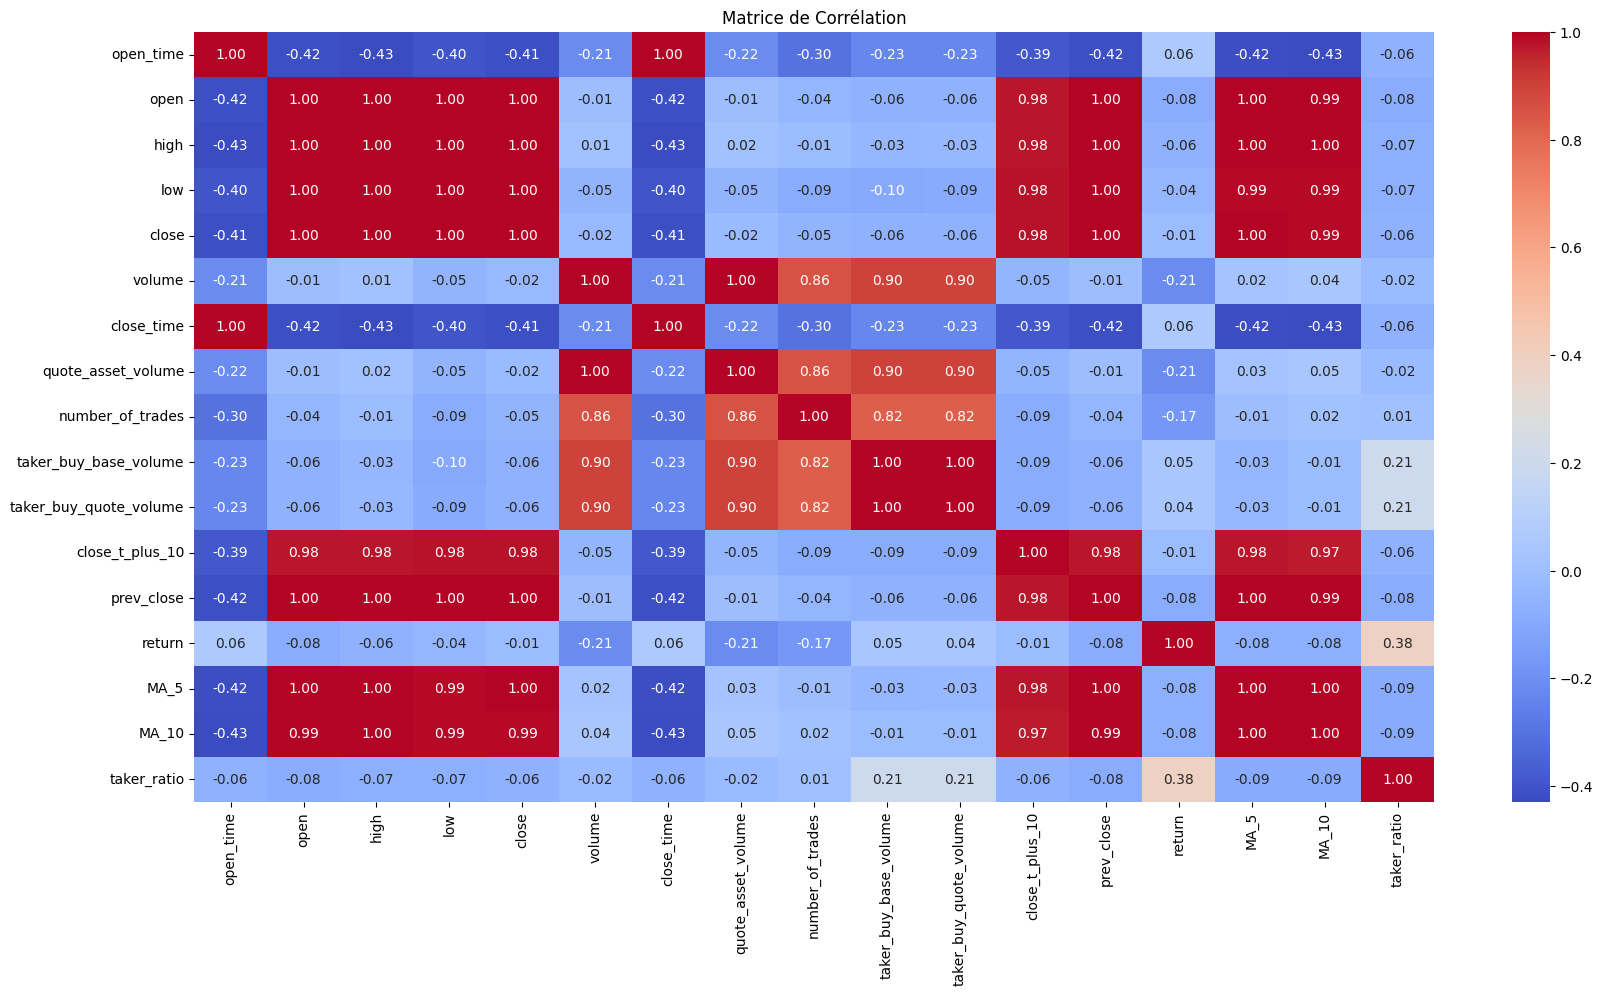

In [147]:
# Matrix de corrélation
corr_matrix = df_silver.toPandas().corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de Corrélation")
plt.show()

#### Définir features et target

In [148]:
# Colonnes utilisées comme features 

# feature_names = ["MA_5", "high", "low", "open", "close", "MA_10", "prev_close","return"]
feature_names = ["close", "MA_10", "MA_5", "prev_close"]
# feature_names = ["return", "MA_5", "MA_10", "taker_ratio", "volume"]

#### Préparer les données

In [149]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def prepare_ml_data(df, feature_names, target_col, train_ratio=0.7):
    print("Preparation des donnees")

    # 1. Vectorisation des features
    assembler = VectorAssembler(
        inputCols=feature_names,
        outputCol="features_raw",
        handleInvalid="skip"
    )
    df = assembler.transform(df)

    # 2. Index temporel
    window = Window.orderBy("open_time")
    df = df.withColumn("time_index", F.row_number().over(window))

    # 3. Split temporel
    total_rows = df.count()
    split_point = int(total_rows * train_ratio)

    df_train_raw = df.filter(F.col("time_index") <= split_point)
    df_test_raw = df.filter(F.col("time_index") > split_point)

    # 4. Normalisation (fit sur train)
    scaler = StandardScaler(
        inputCol="features_raw",
        outputCol="features",
        withStd=True,
        withMean=True
    )

    scaler_model = scaler.fit(df_train_raw)
    df_train = scaler_model.transform(df_train_raw)
    df_test = scaler_model.transform(df_test_raw)

    # 5. Verification fuite temporelle
    train_max_time = df_train.agg(F.max("open_time")).collect()[0][0]
    test_min_time = df_test.agg(F.min("open_time")).collect()[0][0]

    if train_max_time >= test_min_time:
        print("Attention : fuite temporelle detectee")
    else:
        print("Pas de fuite temporelle")

    print("Train:", df_train.count())
    print("Test:", df_test.count())

    return df_train, df_test, scaler_model

In [150]:
df_train, df_test, scaler_model = prepare_ml_data(df_silver, feature_names, target)

# df_train.show(5)
# df_test.show(5)

Preparation des donnees
Pas de fuite temporelle
Train: 691
Test: 297


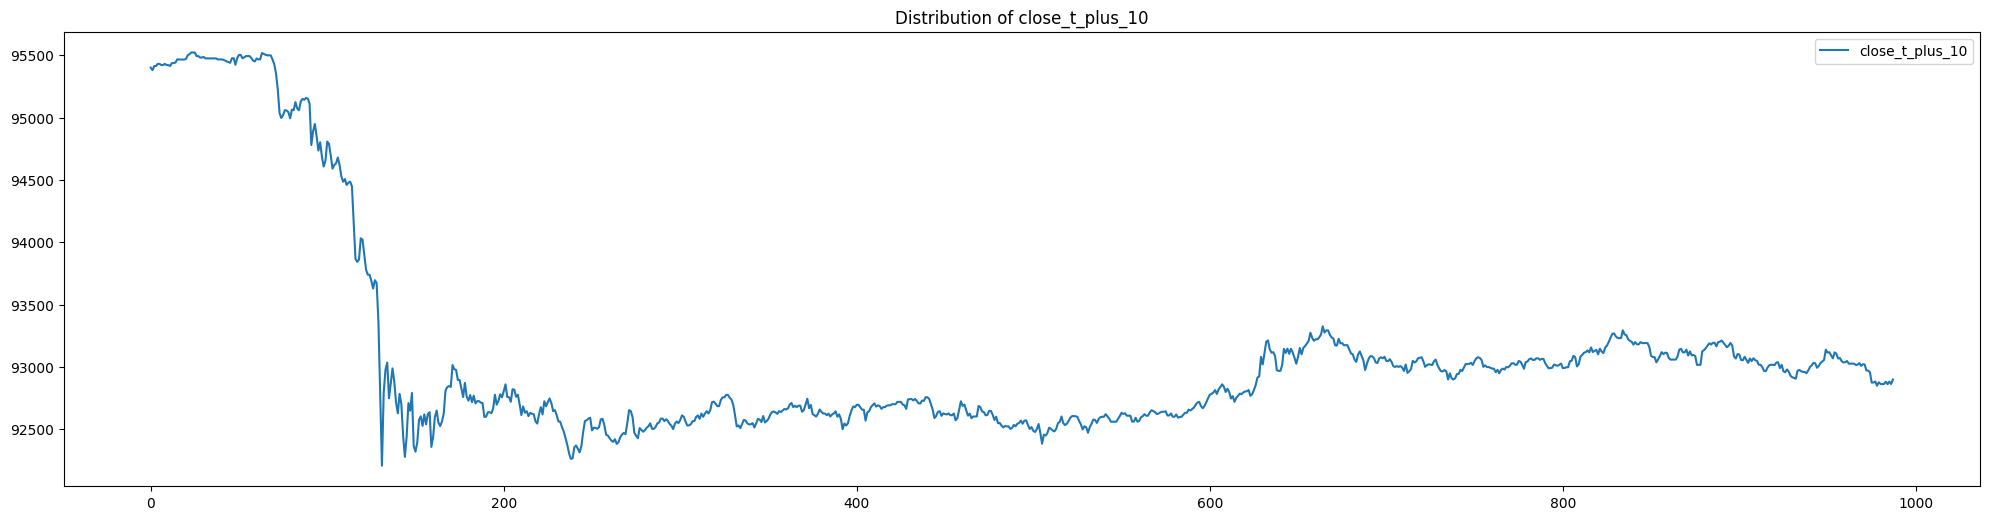

In [151]:
Targets_col = ["close_t_plus_10"]

plt.figure(figsize=(20, 10))
for i, target in enumerate(Targets_col):
    plt.subplot(2, 1, i+1)
    pd_target = df_silver.select(target).toPandas()
    sns.lineplot(data=pd_target)
    plt.title(f'Distribution of {target}')
plt.tight_layout()
plt.show()

In [152]:
def train_linear_regression(df_train, target_col, max_iter=100, reg_param=0.01):
    """
    Entraîne un modèle Linear Regression
    
    Args:
        df_train: DataFrame d'entraînement
        target_col: Colonne cible
        max_iter: Nombre d'itérations
        reg_param: Paramètre de régularisation L2
    
    Returns:
        Modèle entraîné
    """
    print(f"[train_linear_regression] Entraînement...")
    
    lr = LinearRegression(
        featuresCol="features",
        labelCol=target_col,
        maxIter=max_iter,
        regParam=reg_param,
        elasticNetParam=0.0
    )
    
    model = lr.fit(df_train)
    
    print(f"  ✓ Modèle entraîné (RMSE train: {model.summary.rootMeanSquaredError:.2f})")
    
    return model

In [153]:
def train_random_forest(df_train, target_col, num_trees=100, max_depth=10, 
                       min_instances=5, seed=42):
    """
    Entraîne un modèle Random Forest
    
    Args:
        df_train: DataFrame d'entraînement
        target_col: Colonne cible
        num_trees: Nombre d'arbres
        max_depth: Profondeur max des arbres
        min_instances: Instances min par noeud
        seed: Seed pour reproductibilité
    
    Returns:
        Modèle entraîné
    """
    print(f"[train_random_forest] Entraînement...")
    print(f"  - Arbres: {num_trees}, Profondeur: {max_depth}")
    
    rf = RandomForestRegressor(
        featuresCol="features",
        labelCol=target_col,
        numTrees=num_trees,
        maxDepth=max_depth,
        minInstancesPerNode=min_instances,
        seed=seed
    )
    
    model = rf.fit(df_train)
    
    print(f"  ✓ Modèle entraîné")
    
    return model

In [154]:
def train_gbt(df_train, target_col, max_iter=100, max_depth=6, 
             step_size=0.1, seed=42):
    """
    Entraîne un modèle Gradient Boosted Trees
    
    Args:
        df_train: DataFrame d'entraînement
        target_col: Colonne cible
        max_iter: Nombre d'itérations
        max_depth: Profondeur max des arbres
        step_size: Learning rate
        seed: Seed pour reproductibilité
    
    Returns:
        Modèle entraîné
    """
    
    from pyspark.ml.regression import GBTRegressor

    print(f"[train_gbt] Entraînement...")
    print(f"  - Iterations: {max_iter}, Profondeur: {max_depth}, LR: {step_size}")
    
    gbt = GBTRegressor(
        featuresCol="features",
        labelCol=target_col,
        maxIter=max_iter,
        maxDepth=max_depth,
        stepSize=step_size,
        seed=seed
    )
    
    model = gbt.fit(df_train)
    
    print(f"  ✓ Modèle entraîné")
    
    return model

In [155]:
def evaluate_model(model, df_test, target_col, model_name="Model"):
    """
    Évalue un modèle sur le jeu de test
    
    Args:
        model: Modèle entraîné
        df_test: DataFrame de test
        target_col: Colonne cible
        model_name: Nom du modèle (pour affichage)
    
    Returns:
        Dict avec métriques {rmse, mae, r2}
    """
    print(f"[evaluate_model] Évaluation {model_name}...")
    
    # Prédictions
    predictions = model.transform(df_test)
    
    # Évaluateurs
    evaluator_rmse = RegressionEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="rmse"
    )
    evaluator_mae = RegressionEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="mae"
    )
    evaluator_r2 = RegressionEvaluator(
        labelCol=target_col, 
        predictionCol="prediction", 
        metricName="r2"
    )
    
    # Calcul des métriques
    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': predictions
    }
    
    print(f"  ✓ RMSE: ${rmse:.2f} | MAE: ${mae:.2f} | R²: {r2:.4f}")
    
    return metrics

In [156]:
# 1) Préparation des données
df_train, df_test, scaler_model = prepare_ml_data(
    df=df_silver,
    feature_names=feature_names,
    target_col=target,
    train_ratio=0.8
)

# 2) Entraînement des modèles
model_lr = train_linear_regression(df_train, target)
model_rf = train_random_forest(df_train, target)
model_gbt = train_gbt(df_train, target)

# 3) Évaluation
metrics_lr = evaluate_model(model_lr, df_test, target, model_name="Linear Regression")
metrics_rf = evaluate_model(model_rf, df_test, target, model_name="Random Forest")
metrics_gbt = evaluate_model(model_gbt, df_test, target, model_name="GBT")




Preparation des donnees
Pas de fuite temporelle
Train: 790
Test: 198
[train_linear_regression] Entraînement...
  ✓ Modèle entraîné (RMSE train: 172.98)
[train_random_forest] Entraînement...
  - Arbres: 100, Profondeur: 10
  ✓ Modèle entraîné
[train_gbt] Entraînement...
  - Iterations: 100, Profondeur: 6, LR: 0.1
  ✓ Modèle entraîné
[evaluate_model] Évaluation Linear Regression...
  ✓ RMSE: $79.17 | MAE: $64.63 | R²: 0.3171
[evaluate_model] Évaluation Random Forest...
  ✓ RMSE: $68.46 | MAE: $55.82 | R²: 0.4894
[evaluate_model] Évaluation GBT...
  ✓ RMSE: $75.47 | MAE: $61.07 | R²: 0.3795


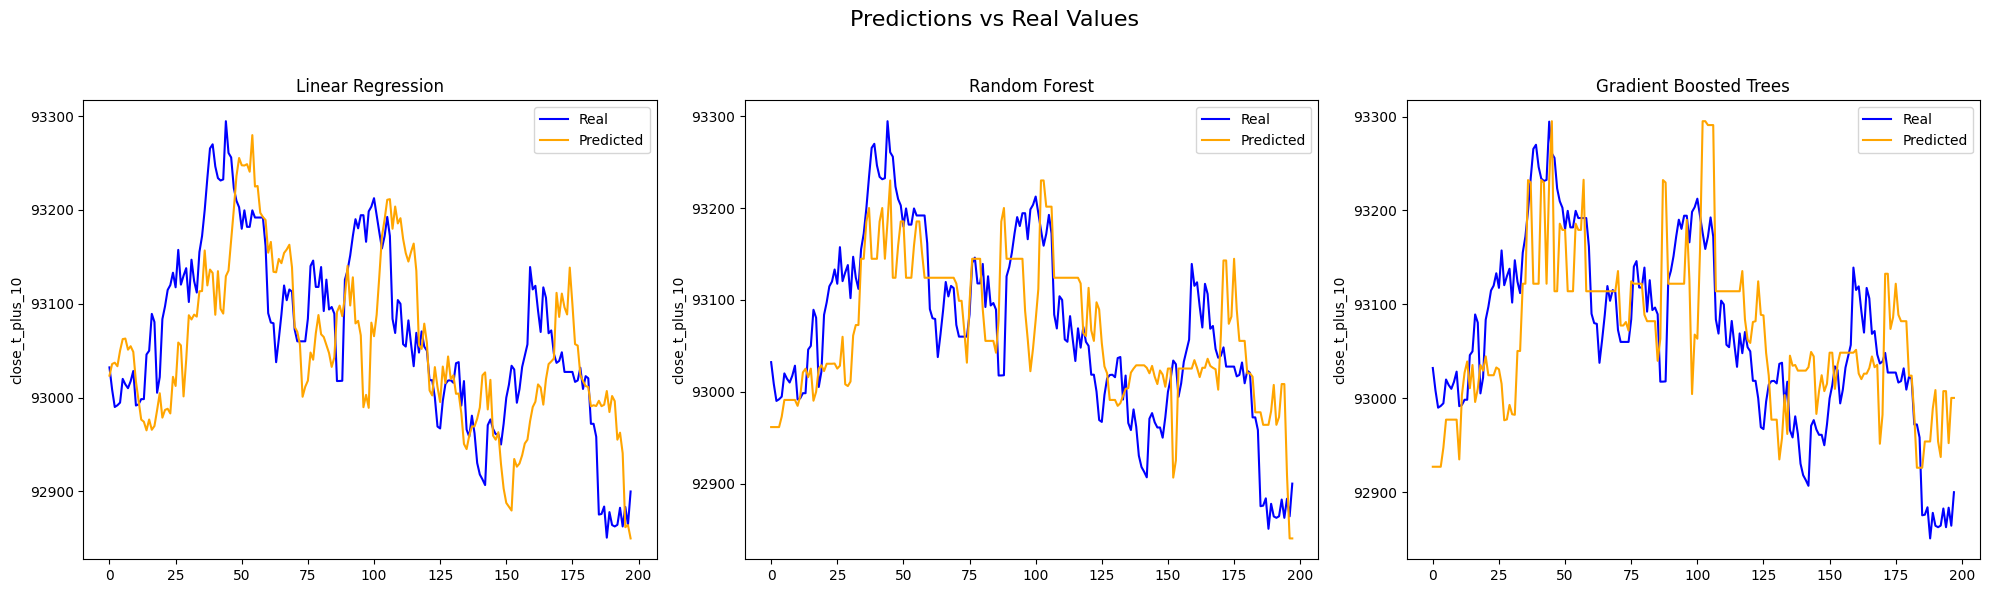

In [157]:
# 3) Affichage des prédictions vs réelles each model

predictions_lr = metrics_lr['predictions']
Prediction_values_lr = predictions_lr.select("prediction").toPandas()["prediction"].head(200000)

predictions_rf = metrics_rf['predictions']
Prediction_values_rf = predictions_rf.select("prediction").toPandas()["prediction"].head(200000)

predictions_gbt = metrics_gbt['predictions']
Prediction_values_gbt = predictions_gbt.select("prediction").toPandas()["prediction"].head(200000)

Real_values = df_test.select(target).toPandas()[target].head(200000)

list_predictions = [
    ("Linear Regression", Prediction_values_lr),
    ("Random Forest", Prediction_values_rf),
    ("Gradient Boosted Trees", Prediction_values_gbt)
]

plt.figure(figsize=(20, 6))

for i, (model_name, prediction_values) in enumerate(list_predictions, 1):
    plt.subplot(1, len(list_predictions), i)  # 1 row, 3 columns
    sns.lineplot(data=Real_values, label="Real", color="blue")
    sns.lineplot(data=prediction_values, label="Predicted", color="orange")
    plt.title(model_name)
    plt.legend()

plt.suptitle("Predictions vs Real Values", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [158]:
# ===== SAUVEGARDER LE MODÈLE =====
print("\nSauvegarde du modèle...")
model_rf.write().overwrite().save("../model/bitcoin_rfs_model")
print("Modèle sauvegardé: bitcoin_rfs_model/")


Sauvegarde du modèle...
Modèle sauvegardé: bitcoin_rfs_model/
